# LH5, DataGroup, and DSP Optimization Tutorial

C. Wiseman, UW, Nov 28 2021

We want to be able to **quickly find optimal DSP parameters to get the best energy resolution and pulse shape discrimination**.  
Users should be able to run this notebook to manually search for "best guess" parameters. 

You can select a group of files to analyze using the `fileDB.h5` and a pandas query for a particular set of files.  This notebook only needs the **raw LH5 files,** and requires the user just manually select the **1460 and 2615** keV peaks, using the onboard energy parameter from the Struck card. 

Here are a few things we want to do in this notebook:

- Show an example of `DataGroup`, which is frequently used for detector test stand setups (CAGE, HADES, SURF, etc.)
- Give examples of **creating and reading LH5 files**, which are required by pygama's `ProcessingChain` DSP class.
- **Optimize pole-zero corrections** to flatten the waveforms in `[4250:5500], [4250:8000]`
- **Optimize energy trapezoid** integration and flat top times (including asymmetric trap) to get best energy resolution
- **Optimize DCR parameter** -- vary the windows used to maximize alpha/gamma separation
- TODO: Optimize energy with charge trapping correction (see notes at the end)

In [1]:
import os, sys, h5py, json, time
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# use this to get interactive plots at NERSC.  
# requires ipympl & jupyter-matplotlib extension for jupyterlab
# user may need to $pip install ipympl --update
%matplotlib widget

import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from tqdm import tqdm
    tqdm.pandas() # suppress annoying FutureWarning

import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
from pygama import DataGroup, lh5
from pygama.dsp.dsp_optimize import *
from pygama.dsp.WaveformBrowser import WaveformBrowser as wfb

# from optimizer_v6_grid import fom1

In [2]:
# << -- CONFIG -- >> # 

# set query
# query = "run == 280" # "2185-2212", "alp", "elog 364. overnight alpha run"
query = 'cycle > 2185 and cycle < 2188'

# set raw energy estimator
etype = 'energy'
tb_in = 'ORSIS3302DecoderForEnergy/raw'
wf_in = 'ORSIS3302DecoderForEnergy/raw/waveform'
xlo, xhi, xpb = 0, 4e6, 10000

# set rough calibration: user fills this in from the first plot, below
peaks = {
    '40K':  [1460.8, 1.71e6],
    '208TL':[2614.5, 3.06e6]
}

# set up a WaveformBrowser for just one of the peaks (user-selected)
pk_select = '208TL'
# pk_select = '40K'

In [3]:
# load data from the raw files.
# we need cycle number and packet index information to retreive waveforms, so make a dataframe

dg = DataGroup('metadata/cage.json', load=True)
dg.fileDB.query(query, inplace=True)

if len(dg.fileDB)==0:
    print('Error, no files found.  Check your query, and fileDB.h5.')
    dg.fileDB[['runtype', 'run', 'cycle']]

def load_file(row):
    data_cols = [etype, 'ievt']
    raw_file = dg.lh5_dir + row['raw_path'] + '/' + row['raw_file']
    raw_cycle = row.cycle
    raw_data = pd.DataFrame(lh5.load_nda(raw_file, data_cols, tb_in, verbose=False))
    raw_data['cycle'] = row['cycle']
    return raw_data
        
result = dg.fileDB.progress_apply(load_file, axis=1)
df_data = pd.concat([r for r in result])
df_mem = round(sys.getsizeof(df_data) / 1024 / 1024, 2)

print('Found unique cycles:', df_data['cycle'].unique())
print(f"Entries found: {df_data.shape}")
print('In-memory size:', df_mem, "MB")

raw_files = dg.lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']

with h5py.File(raw_files.iloc[0], 'r') as hf:
    print('LH5 columns found :', list(hf[f'{tb_in}'].keys()))
    
df_data

100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

Found unique cycles: [2186 2187]
Entries found: (228055, 3)
In-memory size: 5.22 MB
LH5 columns found : ['card', 'channel', 'crate', 'energy', 'energy_first', 'ievt', 'packet_id', 'timestamp', 'waveform']


,energy,ievt,cycle
0,266055,0,2186
1,367651,1,2186
2,193344,2,2186
3,213513,3,2186
4,127953,4,2186
...,...,...,...
114002,116451,114002,2187
114003,1027450,114003,2187
114004,68319,114004,2187
114005,1707476,114005,2187


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
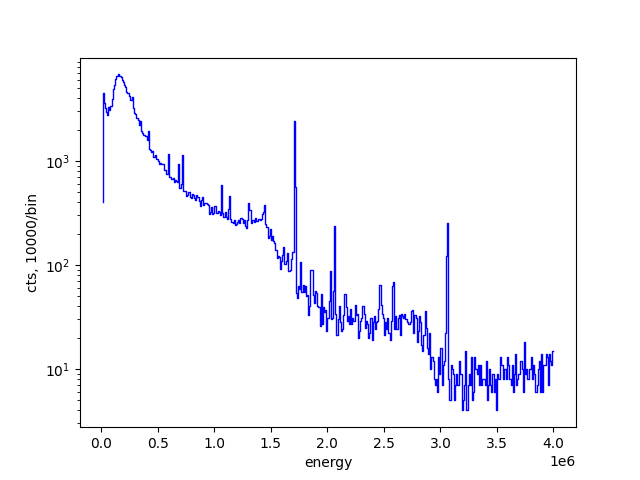

Hey, you need to zoom in and pick out the locations of the 1460 and 2615 peaks and write them into the config at the top!


In [4]:
# create raw energy histogram
%matplotlib widget
hist, bins, var = pgh.get_hist(df_data['energy'], range=(xlo, xhi), dx=xpb)
bins = bins[1:] # trim zero bin, not needed with ds='steps'
plt.semilogy(bins, hist, ds='steps', c='b', lw=1, label=etype)
plt.xlabel(etype)
plt.ylabel(f'cts, {xpb}/bin')
plt.show()
print('Hey, you need to zoom in and pick out the locations of the 1460 and 2615 peaks and write them into the config at the top!')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
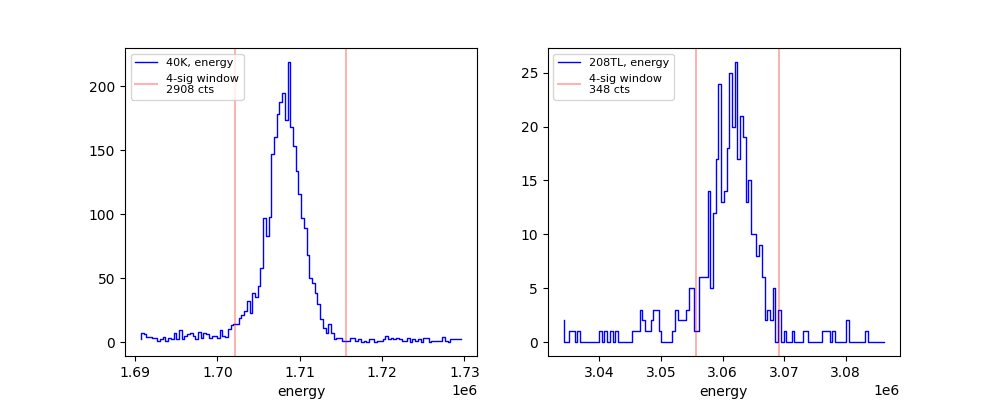

In [5]:
%matplotlib widget

# select events in peaks using a rough FWHM, optimized for onboard energy.
# this should work automatically if 'peaks' is correct.
# a lot of this is reused from CAGE energy_cal.py :: fit_peaks

evts_pass = {}

# adjustable parameters for auto-binning
win_multip = 30
nbin_gain = 4
nevt_max = 5000 # num. waveforms to retrieve from each peak
nsig_save = 4 # num. sig to save.  may need to be able to re-fit the whole peak

fig, axs = plt.subplots(1, len(peaks), figsize=(len(peaks)*5, 4))

for ipk, (pk, (cal_e, raw_e)) in enumerate(peaks.items()):
    
    # set the window.  assume resolution goes as roughly sqrt(energy).
    window = np.sqrt(raw_e) * win_multip
    plo, phi = raw_e - window / 2, raw_e + window / 2
    nbin_scale = nbin_gain * np.sqrt(raw_e) / raw_e
    nbins = int(window) * nbin_scale
    ppb = (phi - plo) / nbins
    
    h, b, var = pgh.get_hist(df_data[etype], range=(plo, phi), dx=ppb)
    b = b[1:]
    
    # get fwhm and select events in the window (ix_evts).  don't need to fit here.
    imax = np.argmax(h)
    ix_upr = np.where((b > b[imax]) & (h <= np.amax(h)/2))
    ix_bot = np.where((b < b[imax]) & (h <= np.amax(h)/2))
    
    upr_half = b[ix_upr][0]
    bot_half = b[ix_bot][-1]
    fwhm0 = upr_half - bot_half
    sig0 = fwhm0 / 2.355

    raw_ctr = b[imax]
    raw_lo = raw_ctr - sig0 * nsig_save
    raw_hi = raw_ctr + sig0 * nsig_save

    # select 'nevt_max' events to save waveforms, but sample evenly throughout the dataset
    df_pass = df_data.loc[(df_data[etype] > raw_lo) & (df_data[etype] < raw_hi)]
    n_evts = len(df_pass)
    n_select = nevt_max if n_evts > nevt_max else n_evts
    evts_pass[pk] = df_pass.sample(n_select).sort_values(['cycle','ievt'])
    # print(evts_pass[pk])
    
    axs[ipk].plot(b, h, ds='steps', c='b', lw=1, label=pk + ', ' + etype)
    axs[ipk].axvline(raw_lo, c='r', alpha=0.3, label=f'{nsig_save}-sig window\n{n_evts} cts')
    axs[ipk].axvline(raw_hi, c='r', alpha=0.3)
    axs[ipk].legend(fontsize=8, loc=2)
    axs[ipk].set_xlabel(etype)

In [6]:
# save waveforms for events in peaks into memory as an LH5 table (and to disk).
# this can take a long time, which is why it's nice to only run once.

sto = lh5.Store()

tb_wfs = {} # LH5 tables for each peak

# write the data to a temporary LH5 file usable by WaveformBrowser
f_wfs = './wfs_optimizer.lh5' 
if os.path.exists(f_wfs):
    os.remove(f_wfs) # write_object :: append=False can't create a new file

for pk, df_evts in evts_pass.items():
    print(f'Loading {pk} peak data ...')
    
    raw_files = dg.lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']
    raw_files = list(raw_files)
    
    df_idxs = df_evts.groupby('cycle').agg({'ievt' : lambda x: list(x)})
    raw_idxs = df_idxs['ievt'].values
    raw_idxs = list(raw_idxs)
    
    # this step can take a while, so time it
    t_start = time.time()
    tb_wfs[pk], n_wfs = sto.read_object(tb_in, raw_files, idx=raw_idxs)
    t_elap = (time.time() - t_start) / 60
    print(tb_wfs[pk]['waveform']['values'].nda.shape)
    print(f'    Waveforms loaded.  Elapsed time: {t_elap:.2f} min.')
    
    # some handy debug statements looking at h5py dset attrs, etc
    # tb_wfs[pk].attrs['datatype'] = 'table{t0, dt, values}' # required by WaveformBrowser
    # print(dir(tb_wfs[pk]))
    # print(tb_wfs.keys())
    # tb_raw = lh5.Table(col_dict={'waveform':tb_wfs[pk]})
    # tb_raw.attrs['datatype'] = 'table{waveform}'
    
    sto.write_object(tb_wfs[pk], f'{tb_in}/{pk}', f_wfs, append=True)

Loading 40K peak data ...
(2908, 8192)
    Waveforms loaded.  Elapsed time: 0.11 min.
Loading 208TL peak data ...
(348, 8192)
    Waveforms loaded.  Elapsed time: 0.01 min.


In [7]:
# For our output file to work with WaveformBrowser, the LH5 Tables, and their
# HDF5 attrs etc, all need to be the same.  To make sure this is the case,
# compare against the first raw file in our list, which we know is readable
# by WaveformBrowser.

with h5py.File(f_wfs, 'r') as hf:
    print('LH5 columns found :', list(hf[f'{tb_in}/{pk_select}'].keys()))
    
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))
        
# debug -- this is useful for looking at LH5 dataset & attributes
        
# f_input = raw_files[0]
# with h5py.File(f_input, 'r') as hf:
#     print('LH5 columns found :', list(hf[f'{tb_in}'].keys()))
#     hf.visititems(print_attrs)

print('\nnew wfs file:')
f_input = f_wfs
with h5py.File(f_input, 'r') as hf:
    print('LH5 columns found :', list(hf[f'{tb_in}/{pk_select}'].keys()))
    hf.visititems(print_attrs)

LH5 columns found : ['card', 'channel', 'crate', 'energy', 'energy_first', 'ievt', 'packet_id', 'timestamp', 'waveform']

new wfs file:
LH5 columns found : ['card', 'channel', 'crate', 'energy', 'energy_first', 'ievt', 'packet_id', 'timestamp', 'waveform']
ORSIS3302DecoderForEnergy
ORSIS3302DecoderForEnergy/raw
ORSIS3302DecoderForEnergy/raw/208TL
    datatype: table{packet_id,ievt,energy,energy_first,timestamp,crate,card,channel,waveform}
ORSIS3302DecoderForEnergy/raw/208TL/card
    datatype: array<1>{real}
ORSIS3302DecoderForEnergy/raw/208TL/channel
    datatype: array<1>{real}
ORSIS3302DecoderForEnergy/raw/208TL/crate
    datatype: array<1>{real}
ORSIS3302DecoderForEnergy/raw/208TL/energy
    datatype: array<1>{real}
    units: adc
ORSIS3302DecoderForEnergy/raw/208TL/energy_first
    datatype: array<1>{real}
ORSIS3302DecoderForEnergy/raw/208TL/ievt
    datatype: array<1>{real}
ORSIS3302DecoderForEnergy/raw/208TL/packet_id
    datatype: array<1>{real}
ORSIS3302DecoderForEnergy/raw/208

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
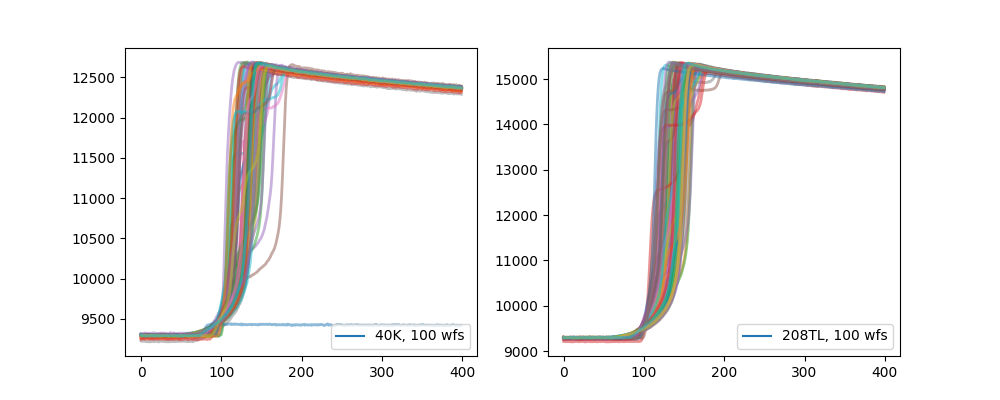

In [8]:
%matplotlib widget

# show some example waveforms from all peaks before running WaveformBrowser and ParGrid.
# limit to the rising edge because it's more interesting.

n_max = 100

fig, axs = plt.subplots(1, len(peaks), figsize=(len(peaks)*5, 4))

for ipk, (pk, (cal_e, raw_e)) in enumerate(peaks.items()):
    
    n_wfs, nsamp = tb_wfs[pk]['waveform']['values'].nda.shape
    n_lim = n_max if n_wfs > n_max else n_wfs
    wfs = tb_wfs[pk]['waveform']['values'].nda[:n_lim,:]
    
    wf_ctr = nsamp / 2
    win_lo, win_hi = int(wf_ctr - 200), int(wf_ctr + 200)
    
    ts = np.arange(0, len(wfs[0, win_lo:win_hi]))
    for iwf in range(wfs.shape[0]):
        axs[ipk].plot(ts, wfs[iwf,win_lo:win_hi], lw=2, alpha=0.5)
    axs[ipk].plot(np.nan, np.nan, label = f'{pk}, {n_lim} wfs')
    axs[ipk].legend(loc=4, fontsize=10)

plt.show()

### 1. Optimize Pole-Zero Correction ('whole-tail')

Here, I want to select values for the pole-zero correction (using the `double_pole_zero` calculator) that give the whole tail after the rising edge as flat of a slope as possible.  The tasks here are:

- Set up a minimal DSP config file 
- Declare a `WaveformBrowser` example to show the pole-zero corrected waveform, so that users can draw various wfs
- Set up a `ParGrid` class and call `run_one_dsp` for ONE set of parameters, to look at how the **figure of merit** works.
- Then in `optimizer_v6_grid.py`, we call the same FOM and run on a larger grid search.

**NOTE:** We really don't need very many waveforms to get the pole-zero correction correct (almost all the tails have the same decay constant).  So we can limit this to like 10-100 waveforms and the `ParGrid` search will run much faster.

In [9]:
# declare the DSP processor list.  later cells will augment these config parameter dict's.

dsp_config = {
    "outputs" : ["bl", "bl_sig", "pztail_mean", "pztail_sig"],
    "processors" : {
         "bl , bl_sig, slope, intercept":{
            "function": "linear_slope_fit",
            "module": "pygama.dsp.processors",
            "args" : ["waveform[:1650]", "bl","bl_sig", "slope","intercept"],
            "unit": ["ADC","ADC","ADC","ADC"]
        },
        "wf_blsub":{
            "function": "subtract",
            "module": "numpy",
            "args": ["waveform", "bl", "wf_blsub"],
            "prereqs": ["waveform", "bl"],
            "unit": "ADC",
        },
        "wf_pz": {
            "function": "double_pole_zero",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_blsub"],
            "args": ["wf_blsub", "db.pz2.tau1", "db.pz2.tau2",  "db.pz2.frac", "wf_pz"],
            "defaults": {"db.pz2.tau1":"187.5*us", "db.pz2.tau2":"3.17*us", "db.pz2.frac":"0.035" },
            "unit" : "ADC"
        },
         "pztail_mean , pztail_sig, pz_slope, pz_intercept":{
            "function": "linear_slope_fit",
            "module": "pygama.dsp.processors",
            "args" : ["wf_pz[4250:8000]", "pztail_mean","pztail_sig", "pz_slope","pz_intercept"],
            "unit": ["ADC","ADC","ADC","ADC"]
        },
    }
}

# try writing to a temporary file
# f_dsp = './dsp_tmp.json'
# with open(f_dsp, 'w') as f:
#     json.dump(dsp_config, f)

# user should MANUALLY edit the parameters of interest to get an idea
# of which range we should pick to optimize with ParGrid.
# this DB will be updated with the 'optimized' parameter choices
# (consider this as an output of this notebook).
# note: description of the formatting is in pygama.dsp.build_processing_chain
dsp_db = {
    "pz2" : {
        "tau1" : "51*us",
        "tau2" : "2*us",
        "frac" : 0.04
    }
}

In [10]:
## -- waveform browser step -- 

# load our skim waveforms file
f_input = f_wfs 
tb_input = f'{tb_in}/{pk_select}'

# debug - load wf browser with raw file 0 & preexisting config
# dsp_config = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_06.json')
# f_input = raw_files[0] # testing, has correct datatypes
# tb_input = f'{tb_in}'

pprint(dsp_db)

b = wfb(f_input, tb_input, dsp_config,
        waveforms=['wf_blsub', 'wf_pz'],
        database=dsp_db,
        # selection = cut,
        wf_styles=[{'linestyle':['-']}, {'linestyle':[':']}],
        #legend=['wf_blsub {bl:.2f}', 'pz-corrected'], # displaying the bl value is tricky
        legend_opts={'loc':"lower right"},
        #lines=['bl'],
        x_lim=(38000, 80000)
       )

{'pz2': {'frac': 0.04, 'tau1': '51*us', 'tau2': '2*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_blsub', 'wf_pz']
Database lookup: found 51*us for db.pz2.tau1
Database lookup: found 2*us for db.pz2.tau2
Database lookup: found 0.04 for db.pz2.frac


[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
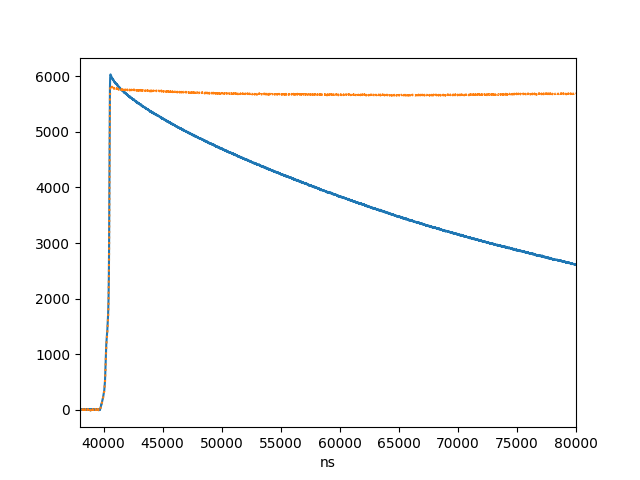

In [11]:
%matplotlib widget
b.draw_next()

Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'pztail_mean , pztail_sig, pz_slope, pz_intercept']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['bl', 'bl_sig', 'pztail_mean', 'pztail_sig']
Database lookup: found 51*us for db.pz2.tau1
Database lookup: found 2*us for db.pz2.tau2
Database lookup: found 0.04 for db.pz2.frac


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
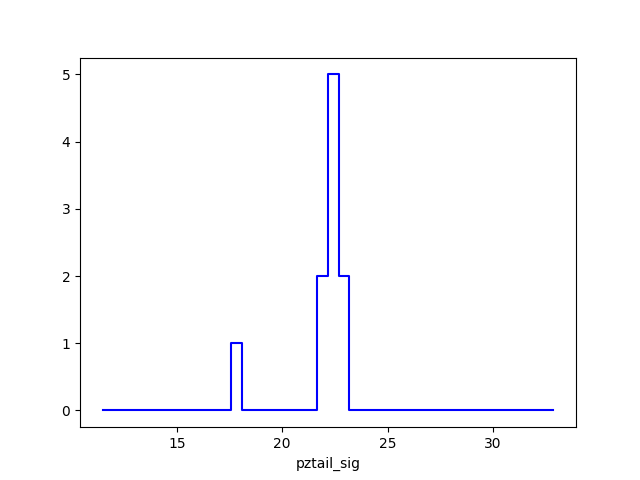

In [17]:
%matplotlib widget

# -- EXAMPLE -- run_one_dsp and evaluate a figure of merit.
# This is automated by the ParGrid class, but it's good to be able to visualize & make plots of what's happening.

col_name = 'pztail_sig'

def mean_val(tb, verbosity, fom_kwargs=None):
    return np.average(tb[col_name].nda)

# limit the number of wfs, we only need ~10--50 to get the pz correction right.  
# it's easier to reload from the file than to try and slice the in-memory `tb_wfs[pk_select]`.
nwfs_lim = 10
sto = lh5.Store()
tb_wfs_slim, n_wfs = sto.read_object(f'{tb_in}/{pk_select}', f_wfs, n_rows=nwfs_lim)

tb_out = run_one_dsp(tb_wfs_slim, dsp_config, db_dict=dsp_db, verbosity=1)

mean = mean_val(tb_out, 0)
xlo, xhi, xpb = mean - mean/2, mean + mean/2, 0.5
h, b, var = pgh.get_hist(tb_out[col_name].nda, range=(xlo, xhi), dx=xpb)
plt.plot(b[1:], h, ds='steps', c='b')
plt.xlabel(col_name)
plt.show()

In [20]:
# ParGrid setup
# internally this calls run_one_dsp with our figure of merit function.
# In the notebook we don't want to run on too many points,
# We can run a really FINE grid search in `optimizer_v6_grid.py` on the batch system.

pg = ParGrid()

# vary tau1, tau2, and frac
tau1_arr = np.linspace(51, 52, 6)
tau2_arr = np.linspace(5.5, 7, 6)
frac_arr = np.linspace(0.03, 0.05, 4)

pg.add_dimension('pz2', 'tau1', [f"{t:.2f}*us" for t in tau1_arr])
pg.add_dimension('pz2', 'tau2', [f"{t:.2f}*us" for t in tau2_arr])
pg.add_dimension('pz2', 'frac', [f"{t:.3f}" for t in frac_arr])

print('tau1:', tau1_arr)
print('tau2:', tau2_arr)
print('frac:', frac_arr)
ngrid = pg.get_n_grid_points()
print('grid points to search:', ngrid)

# the more waveforms we have, the longer it will take to run one grid point
nwfs = tb_wfs_slim['waveform']['values'].nda.shape[0]
print('wfs to reprocess:', nwfs * ngrid)

tau1: [51.  51.2 51.4 51.6 51.8 52. ]
tau2: [5.5 5.8 6.1 6.4 6.7 7. ]
frac: [0.03       0.03666667 0.04333333 0.05      ]
grid points to search: 144
wfs to reprocess: 1440


In [21]:
# run the grid search.

# NOTE: the fom_function does NOT support additional function arguments.
fom_vals = run_grid(tb_wfs_slim, dsp_config, pg, mean_val, verbosity=1)

# unpack the results into a DataFrame.  
# have to iterate thru the n-dimensional grid
grid_nd = []
ix = pg.get_zero_indices()
while True:
    row = []
    for i_dim, i_par in enumerate(ix):
        name, i_arg, value_str = pg.get_data(i_dim, i_par)
        #if '*' in value_str:
        #    val = float(value_str.split('*')[0])
        #else:
        #    val = float(value_str)
        row.append(value_str)
    grid_nd.append(row)
    if not pg.iterate_indices(ix): break

df_grid = pd.DataFrame(grid_nd, columns=['tau1','tau2','frac'])

results_1d = fom_vals.reshape(-1, pg.get_n_grid_points())
df_grid['fom'] = results_1d[0]

print("NOTE: if one of the best settings is at the upper/lower limit of your parameter grid,",
      "\nyou probably need to adjust the grid to find the true min.")

# df_grid # show full df
df_best = df_grid.sort_values('fom')[:5] # show 5 best settings
df_best

starting grid calculations...
Grid point at indices [0 0 0]:
pz2.tau1 = 51.00*us
pz2.tau2 = 5.50*us
pz2.frac = 0.030
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'pztail_mean , pztail_sig, pz_slope, pz_intercept']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['bl', 'bl_sig', 'pztail_mean', 'pztail_sig']
Database lookup: found 51.00*us for db.pz2.tau1
Database lookup: found 5.50*us for db.pz2.tau2
Database lookup: found 0.030 for db.pz2.frac
value: 9.304541
Grid point at indices [0 0 1]:
pz2.tau1 = 51.00*us
pz2.tau2 = 5.50*us
pz2.frac = 0.037
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'pztail_mean , pztail_sig, pz_slope, pz_intercept']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['bl', 'bl_sig', 'pztail_mean', 'pztail_sig']
Database lookup: found 51.00*us for db.pz2.tau1
Database lookup: found 5.50*us for db.pz2.ta

,tau1,tau2,frac,fom
134,52.00*us,6.40*us,0.043,6.004651
106,51.80*us,6.10*us,0.043,6.041416
102,51.80*us,5.80*us,0.043,6.045269
74,51.60*us,5.50*us,0.043,6.057774
138,52.00*us,6.70*us,0.043,6.088762


In [15]:
# finally, update the dsp_db with the best result

dbest = df_best.iloc[0].to_dict()

for par, val in dbest.items():
    if par == 'fom': continue
    dsp_db['pz2'][par] = val

print("NOTE: you can go back and re-run the WaveformBrowser step now,",
     "\nto see the effect of the updated PZ values.")
dsp_db

NOTE: you can go back and re-run the WaveformBrowser step now, 
to see the effect of the updated PZ values.


{'pz2': {'tau1': '52.00*us', 'tau2': '6.40*us', 'frac': '0.043'}}

## 2. Energy Trapezoid Optimization

Our main energy estimator is `trapEftp`, which uses a combination of different trapezoid settings.  The most important ones to get right are in the  "energy trapezoid" `wf_trap` -- the trap filter with a long integration time.  This is used for `trapEmax`.  The fixed-time-pickoff calculation also uses an asymmetric trapezoid to find `t0`, and then we set a "pickoff time".  Jason and Ian have said that as long as the pickoff time selects a point on the flat top of the energy trapezoid, its value is rather arbitrary.  Similarly, the `t0` calculator is fairly robust too, and these parameters shouldn't need to be varied as much as the energy trap parameters.

So here, we're going to optimize `db.etrap.rise`, `db.etrap.flat`, and for fun we can also optimize `db.pz2.tau1` to see if we get a different value than what we got above.  I bet we will ...

In [22]:
# re-declare dsp_config to contain energy trapezoid calculators.
# this is visually simpler than trying to augment the existing dictionary.
# however, we should update the dsp_db dict, since it's the "output" of this notebook.

dsp_config = {
    "outputs" : ["tp_0", "trapEmax", "atrap_max", "trapEftp", "tp_ftp"],
    "processors" : {
         "bl , bl_sig, slope, intercept":{
            "function": "linear_slope_fit",
            "module": "pygama.dsp.processors",
            "args" : ["waveform[:1650]", "bl","bl_sig", "slope","intercept"],
            "unit": ["ADC","ADC","ADC","ADC"]
        },
        "wf_blsub":{
            "function": "subtract",
            "module": "numpy",
            "args": ["waveform", "bl", "wf_blsub"],
            "prereqs": ["waveform", "bl"],
            "unit": "ADC",
        },
        "wf_pz": {
            "function": "double_pole_zero",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_blsub"],
            "args": ["wf_blsub", "db.pz2.tau1", "db.pz2.tau2",  "db.pz2.frac", "wf_pz"],
            "defaults": {"db.pz2.tau1":"187.5*us", "db.pz2.tau2":"3.17*us", "db.pz2.frac":"0.035" },
            "unit" : "ADC"
        },
        "wf_etrap": {
            "function": "trap_norm",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_pz"],
            "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
            "defaults" : {"db.etrap.rise":"4*us", "db.etrap.flat":"1*us"},
            "unit": "ADC"
        },
        "wf_atrap": {
            "function": "asym_trap_filter",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_pz"],
            # "args": ["wf_pz", "round(0.1*us)", "round(1*us)", "round(4*us)", "wf_atrap"], # ian's
            "args": ["wf_pz", "db.atrap.rise", "db.atrap.flat", "db.atrap.fall", "wf_atrap"], # clint's
            "defaults" : {"db.atrap.rise":"20*ns", "db.atrap.flat":"1*us","db.atrap.fall":"4*us"},
            "unit": "ADC"
        },
        "trapEmax": {
            "function": "amax",
            "module": "numpy",
            "args": ["wf_etrap", 1, "trapEmax"],
            "kwargs": {"signature":"(n),()->()", "types":["fi->f"]},
            "unit": "ADC",
            "prereqs": ["wf_etrap"]
        },
         "atrap_max": {
             "function": "argmax",
              "module": "numpy",
              "args": ["wf_atrap", 1, "atrap_max"],
              "kwargs": {"signature":"(n),()->()", "types":["fi->i"]},
              "unit": "ADC",
              "prereqs": ["wf_atrap"]
        },
        "tmax": {
            "function": "argmax",
            "module": "numpy",
            "args": ["wf_atrap", 1, "tmax"],
            "kwargs": {"signature":"(n),()->()", "types":["fi->i"]},
            "unit": "ns"
        },
        "tp_0": {
            "function": "time_point_thresh",
            "module": "pygama.dsp.processors",
            "args": ["wf_atrap", 0, "tmax", 0, "tp_0"],
            "unit": "ns",
        },
         "trapEftp": {
            "function": "fixed_time_pickoff",
            "module": "pygama.dsp.processors",
            "args": ["wf_etrap", "db.tp_ftp.ftp", "trapEftp"],
            "defaults" : {"db.tp_ftp.ftp":"tp_0 + 5.5*us"},
            "unit": "ADC",
            "prereqs": ["wf_etrap", "tp_0"]
        },
        "tp_ftp" : {
            "function":"add",
            "module":"numpy",
            "args":["tp_0", "db.tp_ftp.ftp", "tp_ftp"],
            "defaults" : {"db.tp_ftp.ftp":"tp_0 + 5.5*us"},
            "prereqs":["tp_0"],
            "unit":"ns"
        }
    }
}

# add parameters to dsp_db
dsp_db['etrap'] = {"rise":"4*us", "flat":"2*us"}
dsp_db['atrap'] = {"rise":"20*ns", "flat":"1*us", "fall":"4*us"}
dsp_db['tp_ftp'] = {"ftp":"tp_0 + 5.5*us"} # << this gets trapEftp correct!!
# dsp_db['tp_ftp'] = {"ftp":"5.5*us"} # << this one draws correctly on the plot !! weird.

# pprint(dsp_db)

In [23]:
## -- waveform browser step -- 
# user should MANUALLY edit the parameters of interest to get an idea
# of which ranges & parameters we should pick to optimize with ParGrid

# load our skim waveforms file
f_input = f_wfs 
tb_input = f'{tb_in}/{pk_select}'

print('DB input parameters:')
pprint(dsp_db)

b = wfb(f_input, tb_input, dsp_config,
        waveforms=['wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap'],
        database=dsp_db,
        legend=['wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap'],
        # lines=['trapEftp', 'tp_ftp', 'tp_0'], # hmm, I can't get any of these to work, need to ask ian
        x_lim=(38000, 55000)
       )

DB input parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'etrap': {'flat': '2*us', 'rise': '4*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 5.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap']
Database lookup: found 52.00*us for db.pz2.tau1
Database lookup: found 6.40*us for db.pz2.tau2
Database lookup: found 0.043 for db.pz2.frac
Database lookup: found 4*us for db.etrap.rise
Database lookup: found 2*us for db.etrap.flat
Database lookup: found 20*ns for db.atrap.rise
Database lookup: found 1*us for db.atrap.flat
Database lookup: found 4*us for db.atrap.fall


[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
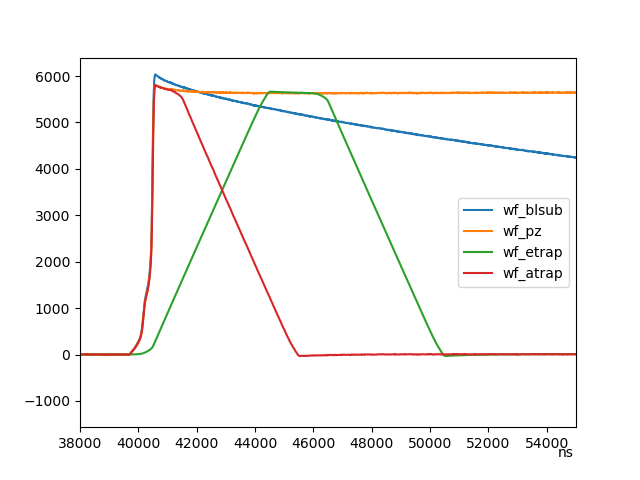

In [24]:
%matplotlib widget
b.draw_next()

DB parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'etrap': {'flat': '2*us', 'rise': '4*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 5.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'wf_atrap', 'tmax', 'tp_0', 'wf_etrap', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['tp_0', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp']
Database lookup: found 52.00*us for db.pz2.tau1
Database lookup: found 6.40*us for db.pz2.tau2
Database lookup: found 0.043 for db.pz2.frac
Database lookup: found 20*ns for db.atrap.rise
Database lookup: found 1*us for db.atrap.flat
Database lookup: found 4*us for db.atrap.fall
Database lookup: found 4*us for db.etrap.rise
Database lookup: found 2*us for db.etrap.flat
Database lookup: found tp_0 + 5.5*us for db.tp_ftp.ftp
Database lookup: found tp_0 + 5.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
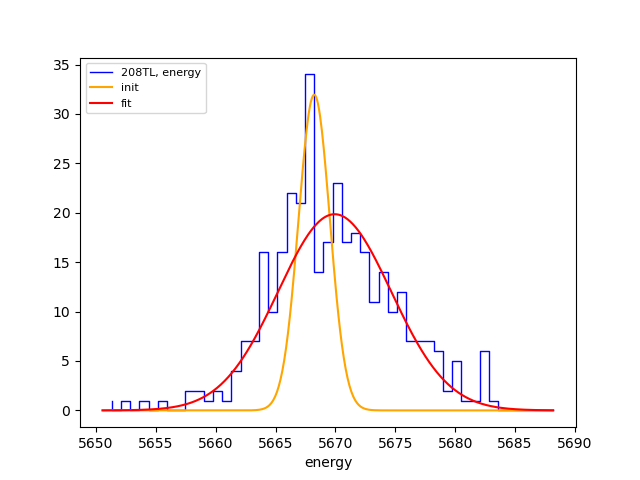

fwhm: 11.11066507839099


,tp_0,trapEmax,atrap_max,trapEftp,tp_ftp
0,39680.0,5663.636719,4059,5646.185059,84860.0
1,39680.0,5670.391113,4060,5652.928711,84860.0
2,39760.0,5679.845215,4033,5653.716797,85020.0
3,39610.0,5664.303711,4058,5646.863770,84720.0
4,39840.0,5675.216309,4046,5651.868652,85180.0
...,...,...,...,...,...
343,39470.0,5671.149902,4059,5657.527344,84440.0
344,39550.0,5665.725098,4060,5650.439941,84600.0
345,39930.0,5655.474121,4025,5632.482422,85360.0
346,39630.0,5666.220703,4079,5654.743652,84760.0


In [25]:
%matplotlib widget

# -- EXAMPLE: try a couple different figures of merit to optimize the
# height/width of our test peak.

# ene_type = 'trapEftp' # this one was giving me issues
ene_type = 'trapEmax' # <-- need to use this one

win_multip = 0.5
nbin_gain = 100

def peak_height(tb, verbosity):
    raw_e = np.mean(tb[ene_type].nda)
    window = np.sqrt(raw_e) * win_multip
    plo, phi = raw_e - window / 2, raw_e + window / 2
    nbin_scale = nbin_gain * np.sqrt(raw_e) / raw_e
    nbins = int(window) * nbin_scale
    ppb = (phi - plo) / nbins
    h, b, var = pgh.get_hist(tb[ene_type].nda, range=(plo, phi), dx=ppb)
    # plt.plot(b[1:], h, ds='steps')
    # plt.show()
    return np.max(h)


def peak_width(tb, verbosity, make_plot=False):
    
    # histogram the data
    raw_e = np.mean(tb[ene_type].nda)
    window = np.sqrt(raw_e) * win_multip
    plo, phi = raw_e - window / 2, raw_e + window / 2
    nbin_scale = nbin_gain * np.sqrt(raw_e) / raw_e
    nbins = int(window) * nbin_scale
    ppb = (phi - plo) / nbins
    h, bins, var = pgh.get_hist(tb[ene_type].nda, range=(plo, phi), dx=ppb)
    b = bins[1:]

    # get initial guesses for simple Gauss fit
    imax = np.argmax(h)
    ix_upr = np.where((b > b[imax]) & (h <= np.amax(h)/2))
    ix_bot = np.where((b < b[imax]) & (h <= np.amax(h)/2))
    upr_half = b[ix_upr][0]
    bot_half = b[ix_bot][-1]
    fwhm0 = upr_half - bot_half
    sig0 = fwhm0 / 2.355
    amp0 = np.amax(h) * fwhm0
    p_init = [b[imax], sig0, amp0]

    # run curve_fit through pygama's wrapper function
    fit_func = pgf.gauss
    p_fit, p_cov = pgf.fit_hist(fit_func, h, bins,
                                var=var, guess=p_init)
    p_err = np.sqrt(np.diag(p_cov))

    if make_plot:
        plt.plot(b, h, ds='steps', c='b', lw=1, label=pk_select + ', ' + etype)
        xfit = np.arange(plo, phi, ppb * 0.1)
        plt.plot(xfit, fit_func(xfit, *p_init), '-', c='orange', label='init')
        plt.plot(xfit, fit_func(xfit, *p_fit), '-', c='red', label='fit')
        plt.legend(fontsize=8, loc=2)
        plt.xlabel(etype)
        plt.show()

    return p_fit[1] * 2.355 # fwhm

print('DB parameters:')
pprint(dsp_db)

# run dsp -- for some reason it's not printing the db.etrap lookup, but seems to use it ...
tb_out = run_one_dsp(tb_wfs[pk_select], dsp_config, db_dict=dsp_db, verbosity=1)

# this is how i examined the problem with tp_ftp and trapEftp 
print(tb_out.keys())
df = tb_out.get_dataframe()

# check figure of merit
height = peak_height(tb_out, 0)
print("counts in max bin:", height)

fwhm = peak_width(tb_out, 0, True)
print("fwhm:", fwhm)

df

In [26]:
# ParGrid setup
# internally this calls run_one_dsp with our figure of merit function.
# In the notebook we don't want to run on too many points,
# We can run a really FINE grid search in `optimizer_v6_grid.py` on the batch system.

pg = ParGrid()

# vary rise, flat, and pz
rise_arr = np.linspace(8, 11, 9)
flat_arr = np.linspace(2, 4, 3)
# pz_arr = np.linspace(51, 51, 1)

pg.add_dimension('wf_etrap', 1, [f"{t:.2f}*us" for t in rise_arr])
pg.add_dimension('wf_etrap', 2, [f"{t:.2f}*us" for t in flat_arr])
# pg.add_dimension('wf_pz', 3, [f"{t:.2f}*us" for t in pz_arr])

print('rise:', rise_arr)
print('flat:', flat_arr)
# print('pz:', pz_arr)
ngrid = pg.get_n_grid_points()
print('grid points to search:', ngrid)

# the more waveforms we have, the longer it will take to run one grid point
nwfs = tb_wfs[pk_select]['waveform']['values'].nda.shape[0]
print('wfs to reprocess:', nwfs * ngrid)

rise: [ 8.     8.375  8.75   9.125  9.5    9.875 10.25  10.625 11.   ]
flat: [2. 3. 4.]
grid points to search: 27
wfs to reprocess: 9396


In [27]:
# run the grid search.

# NOTE: the fom_function does NOT support additional function arguments.
fom_vals = run_grid(tb_wfs[pk_select], dsp_config, pg, peak_width, db_dict=dsp_db, verbosity=0)

# unpack the results into a DataFrame.  
# have to iterate thru the n-dimensional grid
grid_nd = []
ix = pg.get_zero_indices()
while True:
    row = []
    for i_dim, i_par in enumerate(ix):
        name, i_arg, value_str, _ = pg.get_data(i_dim, i_par)
        #if '*' in value_str:
        #    val = float(value_str.split('*')[0])
        #else:
        #    val = float(value_str)
        row.append(value_str)
    grid_nd.append(row)
    if not pg.iterate_indices(ix): break

df_grid = pd.DataFrame(grid_nd, columns=['rise','flat'])

results_1d = fom_vals.reshape(-1, pg.get_n_grid_points())
df_grid['fom'] = results_1d[0]

print("NOTE: if one of the best settings is at the upper/lower limit of your parameter grid,",
      "\nyou probably need to adjust the grid to find the true min.")

# df_grid # show full df
df_best = df_grid.sort_values('fom')
df_best[:5]

NOTE: if one of the best settings is at the upper/lower limit of your parameter grid, 
you probably need to adjust the grid to find the true min.


,rise,flat,fom
25,11.00*us,3.00*us,9.299865
18,10.25*us,2.00*us,9.304938
22,10.62*us,3.00*us,9.339895
20,10.25*us,4.00*us,9.371151
23,10.62*us,4.00*us,9.387618


In [28]:
# update the dsp_db with the best result.
print(df_best.iloc[0])
dbest = df_grid.sort_values('fom').iloc[0].to_dict()

for par, val in dbest.items():
    if par == 'fom': continue
    dsp_db['etrap'][par] = val
    
# tp_ftp should be updated to tp_0 + rise + flat/2 automatically, or you're gonna forget ...
rt = float(dsp_db['etrap']['rise'].split('*')[0])
ft = float(dsp_db['etrap']['flat'].split('*')[0])
dsp_db['tp_ftp']['ftp'] = f'tp_0 + {rt+ft/2}*us'

print("NOTE 1: you can go back and re-run the WaveformBrowser step now,",
     "\nto see the effect of the updated values.")

dsp_db



rise    11.00*us
flat     3.00*us
fom     9.299865
Name: 25, dtype: object
NOTE 1: you can go back and re-run the WaveformBrowser step now, 
to see the effect of the updated values.


{'pz2': {'tau1': '52.00*us', 'tau2': '6.40*us', 'frac': '0.043'},
 'etrap': {'rise': '11.00*us', 'flat': '3.00*us'},
 'atrap': {'rise': '20*ns', 'flat': '1*us', 'fall': '4*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}

DB parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'wf_atrap', 'tmax', 'tp_0', 'wf_etrap', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['tp_0', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp']
Database lookup: found 52.00*us for db.pz2.tau1
Database lookup: found 6.40*us for db.pz2.tau2
Database lookup: found 0.043 for db.pz2.frac
Database lookup: found 20*ns for db.atrap.rise
Database lookup: found 1*us for db.atrap.flat
Database lookup: found 4*us for db.atrap.fall
Database lookup: found tp_0 + 12.5*us for db.tp_ftp.ftp
Database lookup: found tp_0 + 12.5*us for db.tp_ftp.ftp
dict_keys(['tp_0', 'trapEmax', 'atrap_max', 'trapEftp', 'tp

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
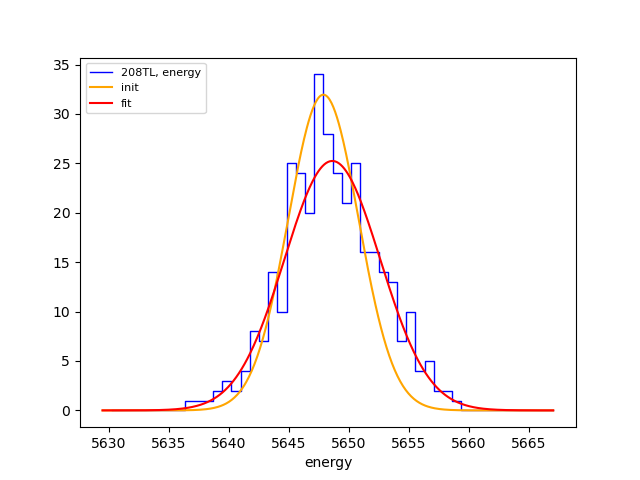

fwhm: 9.394144132651142


,tp_0,trapEmax,atrap_max,trapEftp,tp_ftp
0,39680.0,5643.377930,4059,5637.273438,91860.0
1,39680.0,5649.001465,4060,5642.602539,91860.0
2,39760.0,5655.254883,4033,5645.997070,92020.0
3,39610.0,5642.471680,4058,5636.561523,91720.0
4,39840.0,5651.721191,4046,5643.780273,92180.0
...,...,...,...,...,...
343,39470.0,5650.883789,4059,5646.072754,91440.0
344,39550.0,5643.747070,4060,5638.316895,91600.0
345,39930.0,5638.919922,4025,5632.106445,92360.0
346,39630.0,5647.990723,4079,5644.301270,91760.0


In [29]:
%matplotlib widget

# run dsp with the best result and check resolution

print('DB parameters:')
pprint(dsp_db)
# pprint(dsp_config)

# run dsp
tb_out = run_one_dsp(tb_wfs[pk_select], dsp_config, db_dict=dsp_db, verbosity=1)

# this is how i examined the problem with tp_ftp and trapEftp 
print(tb_out.keys())
df = tb_out.get_dataframe()


# check figure of merit
height = peak_height(tb_out, 0)
print("counts in max bin:", height)

fwhm = peak_width(tb_out, 0, True)
print("fwhm:", fwhm)

df

In [30]:
# load our skim waveforms file
f_input = f_wfs 
tb_input = f'{tb_in}/{pk_select}'

print('DB input parameters:')
pprint(dsp_db)

b = wfb(f_input, tb_input, dsp_config,
        waveforms=['wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap'],
        database=dsp_db,
        legend=['wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap'],
        lines=['tp_ftp', 'tp_0', 'trapEftp', 'tp_ftp'],
        x_lim=(38000, 80000)
       )

DB input parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap', 'tmax', 'tp_0', 'tp_ftp', 'trapEftp']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap', 'tp_ftp', 'tp_0', 'trapEftp', 'tp_ftp']
Database lookup: found 52.00*us for db.pz2.tau1
Database lookup: found 6.40*us for db.pz2.tau2
Database lookup: found 0.043 for db.pz2.frac
Database lookup: found 20*ns for db.atrap.rise
Database lookup: found 1*us for db.atrap.flat
Database lookup: found 4*us for db.atrap.fall
Database lookup: found tp_0 + 12.5*us for db.tp_ftp.ftp
Database lookup: found tp_0 + 12.5*us for db.tp_ftp.ftp


[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
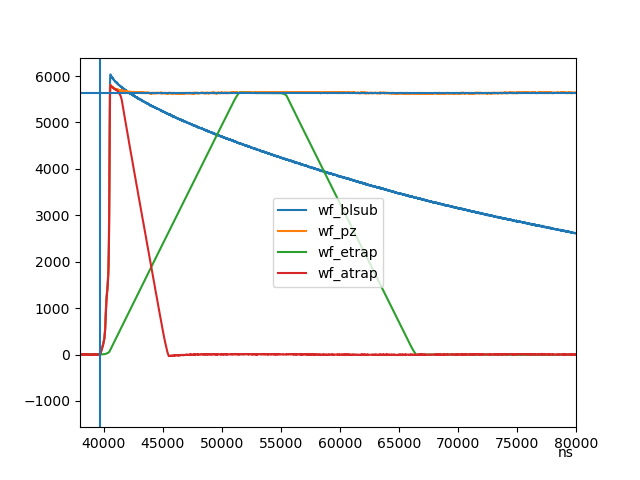

In [31]:
%matplotlib widget
b.draw_next()

In [32]:
pprint(dsp_db)

{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}


## 3. DCR Parameter Optimization

DCR is basically measuring "the slope of the tail" of each waveform.  We know that alpha events tend to have a higher slope, meaning that some excess charge is "trickling in" to the detector much more slowly than the bulk of the charge collection, which creates the rising edge of a signal.  To calculate it, instead of fitting the tail (which is slow), we just take the average in two ~1 us windows on the tail, and subtract them: `DCR = win2 - win1 / len(win)`

In pygama this is equivalent to calculating a trapezoid filter with `rise = win1, win2` and `flat = (spacing between windows)` (typically 10--20 usec), and then evaluating the trapezoid at its first point (a fixed-time pickoff).

In previous CAGE analyses, we've found that varying the window where we optimize the pole-zero correction (so, making another choice than `[4200:8000]` for the tail) can lead to better alpha/gamma event separation.  To optimize DCR, there are sort of two steps:
1. Take a small population of gamma events (so, our 40K or 208TL sample waveforms) and tune `dcr` such that it's as close to zero as possible.  Note there may be an overall trend with energy that you can't really get rid of.
2. Check the alpha-gamma separation in a 2D plot.  Access the first few files in the `raw_files` array to get enough statistics.  This can also take a few minutes to complete `run_one_dsp` so keeping the array sizes as small as possible is useful.

In [33]:
dsp_config = {
    "outputs" : ["tp_0", "trapEmax", "atrap_max", "trapEftp", "tp_ftp", "dcr"],
    "processors" : {
         "bl , bl_sig, slope, intercept":{
            "function": "linear_slope_fit",
            "module": "pygama.dsp.processors",
            "args" : ["waveform[:3500]", "bl","bl_sig", "slope","intercept"],
            "unit": ["ADC","ADC","ADC","ADC"]
        },
        "wf_blsub":{
            "function": "subtract",
            "module": "numpy",
            "args": ["waveform", "bl", "wf_blsub"],
            "prereqs": ["waveform", "bl"],
            "unit": "ADC",
        },
        "wf_pz": {
            "function": "double_pole_zero",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_blsub"],
            "args": ["wf_blsub", "db.pz2.tau1", "db.pz2.tau2",  "db.pz2.frac", "wf_pz"],
            "defaults": {"db.pz2.tau1":"187.5*us", "db.pz2.tau2":"3.17*us", "db.pz2.frac":"0.035" },
            "unit" : "ADC"
        },
        "wf_etrap": {
            "function": "trap_norm",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_pz"],
            "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
            "defaults" : {"db.etrap.rise":"4*us", "db.etrap.flat":"1*us"},
            "unit": "ADC"
        },
"wf_atrap": {
            "function": "asym_trap_filter",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_pz"],
            # "args": ["wf_pz", "round(0.1*us)", "round(1*us)", "round(4*us)", "wf_atrap"], # ian's
            "args": ["wf_pz", "db.atrap.rise", "db.atrap.flat", "db.atrap.fall", "wf_atrap"], # clint's
            "defaults" : {"db.atrap.rise":"20*ns", "db.atrap.flat":"1*us","db.atrap.fall":"4*us"},
            "unit": "ADC"
        },
        "trapEmax": {
            "function": "amax",
            "module": "numpy",
            "args": ["wf_etrap", 1, "trapEmax"],
            "kwargs": {"signature":"(n),()->()", "types":["fi->f"]},
            "unit": "ADC",
            "prereqs": ["wf_etrap"]
        },
         "atrap_max": {
             "function": "argmax",
              "module": "numpy",
              "args": ["wf_atrap", 1, "atrap_max"],
              "kwargs": {"signature":"(n),()->()", "types":["fi->i"]},
              "unit": "ADC",
              "prereqs": ["wf_atrap"]
        },
        "tmax": {
            "function": "argmax",
            "module": "numpy",
            "args": ["wf_atrap", 1, "tmax"],
            "kwargs": {"signature":"(n),()->()", "types":["fi->i"]},
            "unit": "ns"
        },
        "tp_0": {
            "function": "time_point_thresh",
            "module": "pygama.dsp.processors",
            "args": ["wf_atrap", 0, "tmax", 0, "tp_0"],
            "unit": "ns",
        },
         "trapEftp": {
            "function": "fixed_time_pickoff",
            "module": "pygama.dsp.processors",
            "args": ["wf_etrap", "db.tp_ftp.ftp", "trapEftp"],
            "defaults" : {"db.tp_ftp.ftp":"tp_0 + 5.5*us"},
            "unit": "ADC",
            "prereqs": ["wf_etrap", "tp_0"]
        },
        "tp_ftp" : {
            "function":"add",
            "module":"numpy",
            "args":["tp_0", "db.tp_ftp.ftp", "tp_ftp"],
            "defaults" : {"db.tp_ftp.ftp":"tp_0 + 5.5*us"},
            "prereqs":["tp_0"],
            "unit":"ns"
        },
        "wf_pz_dcr": {
            "function": "double_pole_zero",
            "module": "pygama.dsp.processors",
            "prereqs": ["wf_blsub"],
            "args": ["wf_blsub", "db.dcr_pz.tau1", "db.dcr_pz.tau2",  "db.dcr_pz.frac", "wf_pz_dcr"],
            "defaults": {"db.dcr_pz.tau1":"50*us", "db.dcr_pz.tau2":"6*us", "db.dcr_pz.frac":"0.04" },
            "unit" : "ADC"
        },
        "wf_dcr_trap": {
            "function": "trap_norm",
            "module": "pygama.dsp.processors",
            "args": ["wf_pz_dcr", "db.dcr_trap.rise", "db.dcr_trap.flat", "wf_dcr_trap"],
            "defaults" : {"db.dcr_trap.rise":"7.5*us", "db.dcr_trap.flat":"22.5*us"},
            "unit": "ADC",
            "prereqs": ["wf_pz_dcr"]
        },
        "dcr": {
            "function": "fixed_time_pickoff",
            "module": "pygama.dsp.processors",
            "args": ["wf_dcr_trap", "db.dcr.ftp", "dcr"],
            "defaults" : {"db.dcr.ftp" : "79*us"},
            "unit": "ADC",
            "prereqs": ["wf_dcr_trap"]
        }
    }
}

# add parameters to dsp_db
# dsp_db['dcr_pz'] = {"tau1":"52*us", "tau2":"6.*us", "frac":"0.04"}
dsp_db['dcr_pz'] = dsp_db['pz2'] # set equal to best result from above
# dsp_db['dcr_trap'] = {"rise":"7.5*us", "flat":"22.5*us"}
dsp_db['dcr_trap'] = {'flat': '20.33*us', 'rise': '7.00*us'}
dsp_db['dcr'] = {"ftp":"80*us"}

pprint(dsp_db)

{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}


In [34]:
# browse waveforms

f_input = f_wfs 
tb_input = f'{tb_in}/{pk_select}'

print('DB input parameters:')
pprint(dsp_db)

b = wfb(f_input, tb_input, dsp_config,
        waveforms=['wf_blsub', 'wf_pz_dcr', 'wf_dcr_trap'],
        database=dsp_db,
        # legend=['wf_blsub', 'wf_pz_dcr', 'wf_dcr_trap'],
        lines=['dcr'],
        x_lim=(38000, 80000)
       )

DB input parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz_dcr', 'wf_dcr_trap', 'dcr']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_blsub', 'wf_pz_dcr', 'wf_dcr_trap', 'dcr']
Database lookup: found 52.00*us for db.dcr_pz.tau1
Database lookup: found 6.40*us for db.dcr_pz.tau2
Database lookup: found 0.043 for db.dcr_pz.frac
Database lookup: found 7.00*us for db.dcr_trap.rise
Database lookup: found 20.33*us for db.dcr_trap.flat
Database lookup: found 80*us for db.dcr.ftp


[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
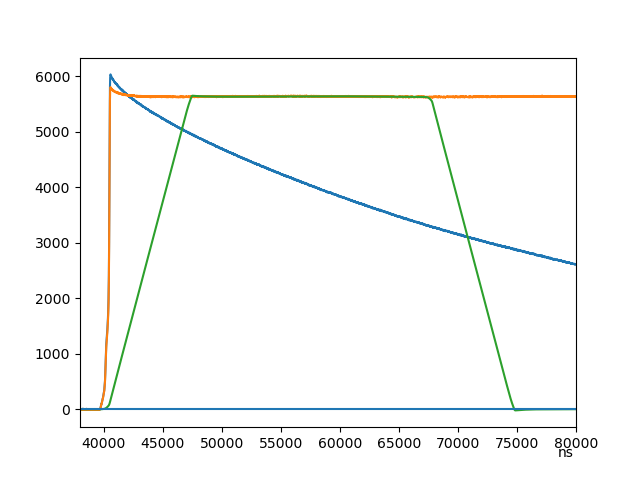

In [35]:
%matplotlib widget
b.draw_next()

DB parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'wf_atrap', 'tmax', 'tp_0', 'wf_etrap', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp', 'wf_pz_dcr', 'wf_dcr_trap', 'dcr']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['tp_0', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp', 'dcr']
Database lookup: found 52.00*us for db.pz2.tau1
Database lookup: found 6.40*us for db.pz2.tau2
Database lookup: found 0.043 for db.pz2.frac
Database lookup: found 20*ns for db.atrap.rise
Database lookup: found 1*us for db.atrap.flat
Database lookup: found 4*u

,tp_0,trapEmax,atrap_max,trapEftp,tp_ftp,dcr
0,39680.0,5643.085938,4059,5637.007324,91860.0,2.812114
1,39680.0,5648.698242,4060,5642.320801,91860.0,1.569476
2,39760.0,5655.303711,4033,5645.975098,92020.0,1.877632
3,39610.0,5642.553223,4058,5636.635742,91720.0,2.855206
4,39840.0,5651.857422,4046,5643.739746,92180.0,-1.130943
...,...,...,...,...,...,...
343,39470.0,5650.850098,4059,5646.133301,91440.0,-1.724350
344,39550.0,5643.747559,4060,5638.332520,91600.0,-1.323630
345,39930.0,5638.937012,4025,5631.930664,92360.0,10.042696
346,39630.0,5648.118164,4079,5644.197266,91760.0,-2.899894


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
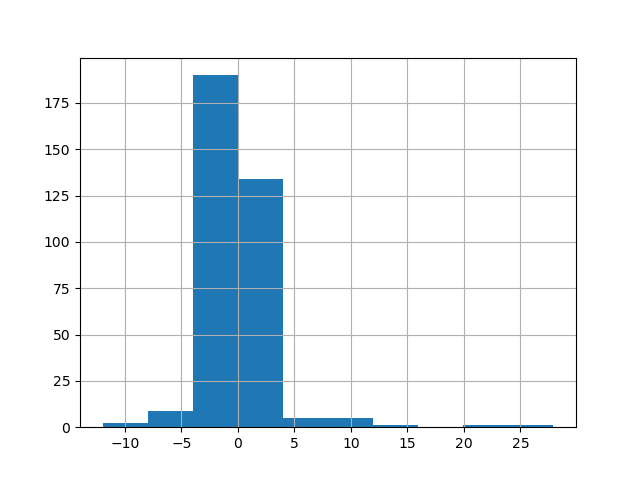

In [36]:
%matplotlib widget

# EXAMPLE -- run_one_dsp with this config file and check the output dataframe.

def mean_val(tb, verbosity, make_plot=False):
    
    if make_plot:
        ps = pd.Series(tb['dcr'].nda)
        ps.hist()
    
    return np.average(tb["dcr"].nda)

print('DB parameters:')
pprint(dsp_db)

# run dsp -- for some reason it's not printing the db.etrap lookup, but seems to use it ...
tb_out = run_one_dsp(tb_wfs[pk_select], dsp_config, db_dict=dsp_db, verbosity=1)

print(tb_out.keys())
df = tb_out.get_dataframe()

# check figure of merit
mean_dcr = mean_val(tb_out, 0, True)
print("mean:", mean_dcr)

df

In [37]:
# ParGrid setup


pg = ParGrid()

# we can vary: dcr_pz.tau1, dcr_pz.tau2, dcr_trap.rise, dcr_trap.flat,
# but the most sensitive parameters should be tau1 and tau2.
# NOTE: we also may want to vary the waveform window, which can only be set in dsp_config

# optimizing tau didn't really do that well, it introduced a lot of curvature.
# seems like it's better to use the best-fit pz corrected waveform found above,
# and then vary rise/flat to try to pin the dcr values of 2615 to 0 ...
# tau1_arr = np.linspace(50, 53, 10)
# tau2_arr = np.linspace(2, 4, 3)
# pg.add_dimension('wf_pz_dcr', 1, [f"{t:.2f}*us" for t in tau1_arr])
# pg.add_dimension('wf_pz_dcr', 2, [f"{t:.2f}*us" for t in tau2_arr])
# print('tau1:', tau1_arr)
# print('tau2:', tau2_arr)

rise_arr = np.linspace(6, 10, 5)
flat_arr = np.linspace(15, 21, 10)
print(rise_arr)
print(flat_arr)

pg.add_dimension('wf_dcr_trap', 1, [f"{t:.2f}*us" for t in rise_arr])
pg.add_dimension('wf_dcr_trap', 2, [f"{t:.2f}*us" for t in flat_arr])

ngrid = pg.get_n_grid_points()
print('grid points to search:', ngrid)

# the more waveforms we have, the longer it will take to run one grid point
nwfs = tb_wfs[pk_select]['waveform']['values'].nda.shape[0]
print('wfs to reprocess:', nwfs * ngrid)

[ 6.  7.  8.  9. 10.]
[15.         15.66666667 16.33333333 17.         17.66666667 18.33333333
 19.         19.66666667 20.33333333 21.        ]
grid points to search: 50
wfs to reprocess: 17400


In [38]:
# run the grid search.

# NOTE: the fom_function does NOT support additional function arguments.
fom_vals = run_grid(tb_wfs[pk_select], dsp_config, pg, mean_val, db_dict=dsp_db, verbosity=0)

# unpack the results into a DataFrame.  
# have to iterate thru the n-dimensional grid
grid_nd = []
ix = pg.get_zero_indices()
while True:
    row = []
    for i_dim, i_par in enumerate(ix):
        name, i_arg, value_str, _ = pg.get_data(i_dim, i_par)
        row.append(value_str)
    grid_nd.append(row)
    if not pg.iterate_indices(ix): break

df_grid = pd.DataFrame(grid_nd, columns=['rise','flat'])

results_1d = fom_vals.reshape(-1, pg.get_n_grid_points())
df_grid['fom'] = results_1d[0]

print("NOTE: if one of the best settings is at the upper/lower limit of your parameter grid,",
      "\nyou probably need to adjust the grid to find the true min.")

# df_grid # show full df
df_best = df_grid.sort_values('fom', key=abs)
df_best[:5]

NOTE: if one of the best settings is at the upper/lower limit of your parameter grid, 
you probably need to adjust the grid to find the true min.


,rise,flat,fom
18,7.00*us,20.33*us,-0.016919
29,8.00*us,21.00*us,0.081243
27,8.00*us,19.67*us,0.085105
28,8.00*us,20.33*us,0.309062
26,8.00*us,19.00*us,-0.423742


In [39]:
# update the dsp_db with the best result.
print(df_best.iloc[0])
dbest = df_grid.sort_values('fom', key=abs).iloc[0].to_dict()

dbest

for par, val in dbest.items():
    if par == 'fom': continue
    dsp_db['dcr_trap'][par] = val
    
print("NOTE: you can go back and re-run the WaveformBrowser step now,",
     "\nto see the effect of the updated values.")

dsp_db



rise     7.00*us
flat    20.33*us
fom    -0.016919
Name: 18, dtype: object
NOTE: you can go back and re-run the WaveformBrowser step now, 
to see the effect of the updated values.


{'pz2': {'tau1': '52.00*us', 'tau2': '6.40*us', 'frac': '0.043'},
 'etrap': {'rise': '11.00*us', 'flat': '3.00*us'},
 'atrap': {'rise': '20*ns', 'flat': '1*us', 'fall': '4*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'},
 'dcr_pz': {'tau1': '52.00*us', 'tau2': '6.40*us', 'frac': '0.043'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'dcr': {'ftp': '80*us'}}

DB parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'wf_atrap', 'tmax', 'tp_0', 'wf_etrap', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp', 'wf_pz_dcr', 'wf_dcr_trap', 'dcr']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['tp_0', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp', 'dcr']
Database lookup: found 52.00*us for db.pz2.tau1
Database lookup: found 6.40*us for db.pz2.tau2
Database lookup: found 0.043 for db.pz2.frac
Database lookup: found 20*ns for db.atrap.rise
Database lookup: found 1*us for db.atrap.flat
Database lookup: found 4*u

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
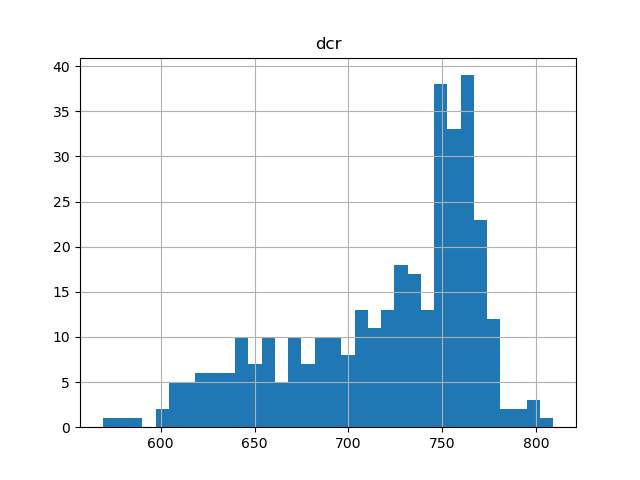

In [40]:
%matplotlib widget

# run dsp with the best result and check the central value of DCR

print('DB parameters:')
pprint(dsp_db)
# pprint(dsp_config)

# run dsp
tb_out = run_one_dsp(tb_wfs[pk_select], dsp_config, db_dict=dsp_db, verbosity=1)

# print(tb_out.keys())
df = tb_out.get_dataframe()
# print(df)

# make a quick histogram of the dcr column.  pandas auto-histogram for a column should be enough
df.hist('dcr', bins=int(len(df) * 0.1))
plt.show()

In [41]:
# load our skim waveforms file
f_input = f_wfs 
tb_input = f'{tb_in}/{pk_select}'

print('DB input parameters:')
pprint(dsp_db)

b = wfb(f_input, tb_input, dsp_config,
        waveforms=['wf_blsub', 'wf_pz', 'wf_pz_dcr', 'wf_dcr_trap'],
        database=dsp_db,
        # legend=['wf_blsub', 'wf_pz', 'wf_etrap', 'wf_atrap'],
        # lines=['tp_ftp', 'tp_0', 'trapEftp', 'tp_ftp'],
        x_lim=(38000, 80000)
       )

DB input parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}
Processing parameters: ['bl , bl_sig, slope, intercept', 'wf_blsub', 'wf_pz', 'wf_pz_dcr', 'wf_dcr_trap']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_blsub', 'wf_pz', 'wf_pz_dcr', 'wf_dcr_trap']
Database lookup: found 52.00*us for db.pz2.tau1
Database lookup: found 6.40*us for db.pz2.tau2
Database lookup: found 0.043 for db.pz2.frac
Database lookup: found 52.00*us for db.dcr_pz.tau1
Database lookup: found 6.40*us for db.dcr_pz.tau2
Database lookup: found 0.043 for db.dcr_pz.frac


[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
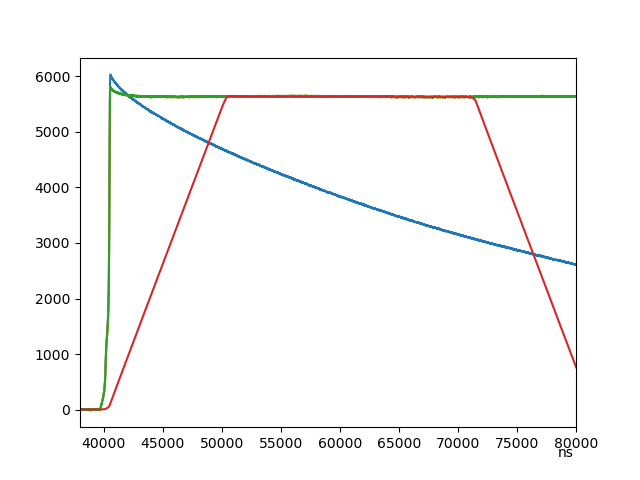

In [42]:
%matplotlib widget
b.draw_next()

In [43]:
pprint(dsp_db)

{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}


In [45]:
#NOTE: now you need to make the 2D plot with DCR vs Energy to see alpha/gamma separation.
# it can take 3-4 minutes to process each file.  
# to speed up the time it takes to search the parameter space, we apply a pretty aggressive low-e cut.
# we can come back and process the full file at the end.

%time
nlim = 1
files_in = raw_files[:nlim]

# run dsp on the full file.  can take a while ... 2-3 mins
print('DB parameters:')
pprint(dsp_db)
# pprint(dsp_config)

# apply low-e cut
# raw_data = pd.DataFrame(lh5.load_nda(raw_file, data_cols, tb_in, verbose=False))
raw_e = lh5.load_nda(raw_files[:nlim], ['energy'], tb_in, verbose=False)

print(type(raw_e['energy']))

ix = np.where(raw_e['energy'] > 1e6)[0] # this is somewhere between 583 and 1460. 
print(type(ix))

print(type(raw_files[:nlim]))

# read the waveforms.  this can take quite a while (3--4 minutes)
tb_data, n_wfs = sto.read_object(tb_in, raw_files[:nlim], idx=ix)
print(n_wfs)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.54 µs
DB parameters:
{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
15336


In [46]:
# DEBUG line -- manually vary dsp_db

# dsp_db['dcr_pz']['tau1'] = "60*us" # best: 52*us
# dsp_db['dcr_pz']['tau2'] = "6.4*us" # best: 6.4*us
# dsp_db['dcr_pz']['frac'] = "0.043" # best: 0.043
# dsp_db['dcr_trap']['rise'] = "8*us"
# dsp_db['dcr_trap']['flat']= "23*us"
# dsp_db['dcr']['ftp'] = "80*us"

# dcr_trap rise/flat maxes: [10, 20], [9, 22]

# run the dsp
tb_out = run_one_dsp(tb_data, dsp_config, db_dict=dsp_db, verbosity=0)
print(tb_out.keys())
df_data = tb_out.get_dataframe()
# df_data

dict_keys(['tp_0', 'trapEmax', 'atrap_max', 'trapEftp', 'tp_ftp', 'dcr'])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
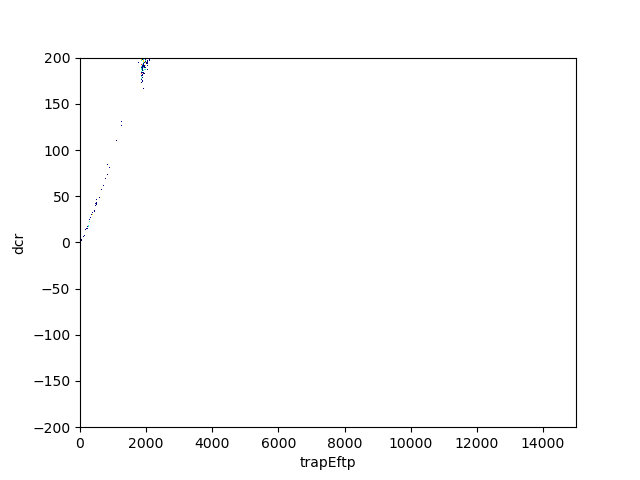

In [47]:
%matplotlib widget
from matplotlib.colors import LogNorm

# 2D plot of DCR vs trapEftp

xlo, xhi, xpb = 0, 15000, 10
ylo, yhi, ypb = -200, 200, 1
# ylo, yhi, ypb = -600, 0, 1

nbx = int((xhi-xlo)/xpb)
nby = int((yhi-ylo)/ypb)

plt.hist2d(df_data.trapEftp, df_data.dcr, range=((xlo,xhi),(ylo,yhi)), bins=(nbx, nby), 
           cmap='jet', norm=LogNorm())

plt.xlabel('trapEftp')
plt.ylabel('dcr')
plt.show()

In [49]:
# finally, write the DB to an output text file.

pprint(dsp_db)

# try writing to a temporary file
f_dsp = './metadata/optimizer_results.json'
with open(f_dsp, 'w') as f:
    json.dump(dsp_db, f)



{'atrap': {'fall': '4*us', 'flat': '1*us', 'rise': '20*ns'},
 'dcr': {'ftp': '80*us'},
 'dcr_pz': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'dcr_trap': {'flat': '20.33*us', 'rise': '7.00*us'},
 'etrap': {'flat': '3.00*us', 'rise': '11.00*us'},
 'pz2': {'frac': '0.043', 'tau1': '52.00*us', 'tau2': '6.40*us'},
 'tp_ftp': {'ftp': 'tp_0 + 12.5*us'}}


## 4. Charge Trapping Correction

Two methods:
    - Drift Time
    - DCR
    
FIRST, you want to optimize the energy trapezoids & pole zero consts by themselves. 
Then, you can improve the resolution further by introducing a corrected parameter.

1. DT method:
Fixed time pickoff should be the same as the ramp time, started at t0.  
Second region must be totally in the flat top, first region starts at t0
The correction should be: `E_new = E + const * qDrift`, but need to check it works for multiple peaks.
It might also be `E_new = E * (1 + const * qDrift)`

2. DCR method: 
DCR-modified E: `E_new = E + const * DCR`
The reason this is as effective as the drift time method is that delayed charge collection from the **bulk** is released w. some time constant on the order of the digitizer window length.  This will make it show up in the tail of the waveforms.  Of course, alpha events have delayed collection from the **surface** as well, which should have a different time constant.

In MJD, charges are significantly trapped but released before next event due to the lower operating temperature, 77 K.
In the STCs and CAGE, the operating temp is closer to 85 or 90 K, and the charge re-release time will be faster. 
So we will have to decide for ourselves if Method 1 (DT) or Method 2 (DCR) is a more effective charge trapping correction for us.

In [51]:
# lol TBD  :-)